In [1]:
import openai
from openai.types import Completion, CompletionChoice, CompletionUsage
import os
import requests
from dotenv import load_dotenv
from scipy.optimize import minimize, Bounds, NonlinearConstraint
from functools import partial 
import time

load_dotenv("/Users/gabriellelittlefair/Documents/GitHub/MSc Project/DSL/hidden.env")
%reload_ext autoreload
from Setup_Functions import *
from Class_Structures import *
from Region import * 
from Individual import * 
from Pairwise import * 
from Whole import * 

In [2]:
## Set up the API calls 
api_key = os.getenv('OPENAI_API_KEY')
client = openai.Client(api_key=api_key)
url = 'https://api.openai.com/v1/chat/completions'
headers = {
    'Authorization': f'Bearer {api_key}', 
    'Content-Type': 'application/json',
        }

## Read in all of the files to be used in the task
file_path1 = '/Users/gabriellelittlefair/Documents/GitHub/MSc Project/BlankConstraints/Setup_Functions.py'
with open(file_path1, 'r') as file:
    file_contents1 = file.read()

file_path2 = '/Users/gabriellelittlefair/Documents/GitHub/MSc Project/BlankConstraints/Individual.py'
with open(file_path2, 'r') as file:
    file_contents2 = file.read()

file_path3 = '/Users/gabriellelittlefair/Documents/GitHub/MSc Project/BlankConstraints/Pairwise.py'
with open(file_path3, 'r') as file:
    file_contents3 = file.read()


def remove_identical_lines(function):
    lines = function.split("\n")
    unique_lines = []
    for line in lines: 
        if line not in unique_lines:
            unique_lines.append(line)
    return("\n").join(unique_lines)


# Set up the Room (all dimensions + fixed features)

### Set the Scene Descriptor

In [3]:
start_time = time.time() # Start the time
scene_descriptor = "a bedroom for a couple."# for a vampire."

### Run the room set up calls (LangPrompt1, Prompt1)

In [14]:
lang_prompt1 = """ I am designing the layout for a """ +  scene_descriptor + """. Give me the dimensions of the room, as well as the number of windows, 
doors, and sockets. For each of these, tell me the dimensions in meters, which wall it should be on, as well as where on the wall it should 
be (a value between 0 and 1 determining how far along the wall it should be). Here is an example for a room and window set up: 
{Room: width = 5, length = 6}, {Object type: window, width = 1, length = 0.1, wall = south, position = 3}. The windows and doors should all 
have length 0.1. Ensure that every object has dimensions, position, and wall. No other text please. Just the list with no commentary or explanation.
"""

lang1output = client.chat.completions.create(
    model="gpt-4o",
    messages=[{"role": "user", "content": lang_prompt1}],
    max_tokens=500
)
objects = lang1output.choices[0].message.content.split("}, {")

prompt1 = """The functions in the following file are used to create a room and out objects in it: """ + file_contents1 + """. The room is described 
as """ +  scene_descriptor + """. For every element in this list, """ + str(objects) + """, translate it into a function call using the file attached.
For example, given the room descriptor 'a small kitchen' as well as the list: {Room: width = 5, length = 6}, 
{Object type: window, Number: 1, width = 1, length = 0.1, wall = south, position = 0.3}, the output would be:
kitchen = create_room(5, 6), create_fixed_object(kitchen, 'window', 1, 0.1, 'south', position = 0.3). Return only the python script. 
No other text. Please ensure the correct number of inputs are given for each function."""

# Define the request payload
data = {
    "model": "gpt-4",
    "messages": [
        {"role": "user", "content": prompt1}
    ]
}

# Make the API call
response1 = requests.post(url, headers=headers, json=data)  
# Check the response
if response1.status_code == 200:
    response_data1 = response1.json()
    if "```python" in response_data1['choices'][0]['message']['content']:
        response1 = (response_data1['choices'][0]['message']['content'].split("```python")[1]).split("```")[0]
    elif "```" in response_data1['choices'][0]['message']['content']:
        response1 = (response_data1['choices'][0]['message']['content'].split("```")[1]).split("```")[0]
    else: 
        response1 = response_data1['choices'][0]['message']['content']
else:
    print('Failed to get a response')
    print(response1.text)

## Account for any additional function calls (of other functions) by only taking the lines in the code that are relevant to the task   
lines = response1.split("\n")
response1 = [i for i in lines if 'create_room' in i]
## If the room is not defined properly, correct it
for line in response1: 
    if '=' not in line: 
        response1 = ['room = ' + line]
for line in lines[1:]: 
    if "create_fixed_object" in line: 
        response1.append(line)

response1 = ("\n").join(response1)

width = (response1.split("create_room("))[1].split(",")[0]
length = (response1.split("create_room("))[1].split(",")[1].split(")")[0]
room_name = (response1.split("create_room("))[0].split("=")[0].strip()

lang_prompt2 = """ I am designing the layout of a """ + scene_descriptor + " that is " + width + "m x " + length + """m. Interior designers
suggest that a good layout will have different regions in the room for different functions. What regions should I use, and how many regions 
(minimum is 1 region - for smaller rooms give fewer regions) should there be based on the description, as well as the size of the room (if the room is small, don't give too many regions). 
Some rooms may only need one region and that's okay. Return this as a simple bullet list of regions to include. Return these in list of priority order. 
Only return the list of regions. No other information please."""

lang2output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt2}],
        max_tokens=500
    )

prompt2 = "Given the room name: " + room_name + ", and the regions: " + lang2output.choices[0].message.content + """, using the function region_setup defined below, 
initialise each region. For example 'eating region' might output 'region_setup(kitchen, 'eating', 0). No other text please, 
only the python script. Don't include the function in the output. The function is: 
def region_setup(room_name, name, index):
    '''A function that initialises the regions in a room randomly.
        Inputs:
        room_name: Room obj (this should be the name of the room)
        name: str, the name of the region e.g 'sleeping'
        index: int, the index of the region (0, 1, 2, ...). First one must be 0, and the rest must be in order.
    '''
    return
"""
# Define the request payload
data = {
    "model": "gpt-4",
    "messages": [
            {"role": "user", "content": prompt2}
            ]
    }
    
# Make the API call
response2 = requests.post(url, headers=headers, json=data)  
# Check the response
if response2.status_code == 200:
    response_data2 = response2.json()
    if "```python" in response_data2['choices'][0]['message']['content']:
        response2 = (response_data2['choices'][0]['message']['content'].split("```python")[1]).split("```")[0]
    else: 
        response2 = response_data2['choices'][0]['message']['content']
        
    global_context = globals().copy()
    local_context = {}  
    exec(response1 + "\n" + response2.replace("'" + room_name + "'", room_name), global_context, local_context)
else:
    print('Failed to get a response')
    print(response2.text)

fixed_objects = ""
for i in range(len(local_context[room_name].fixed_objects)):
    if i < len(local_context[room_name].fixed_objects) - 1:
        fixed_objects +=local_context[room_name].fixed_objects[i].name + ", "
    else: 
        fixed_objects += local_context[room_name].fixed_objects[i].name + "."

region_names = ""
list_region_names = []
for i in range(len(local_context[room_name].regions)):
    if i < len(local_context[room_name].regions) - 1:
        region_names += local_context[room_name].regions[i].name + ", "
        list_region_names.append(local_context[room_name].regions[i].name)  
    else: 
        region_names += local_context[room_name].regions[i].name + "."
        list_region_names.append(local_context[room_name].regions[i].name)
num_primary_objects = len(list_region_names)
num_regions = len(list_region_names)

if "'" + room_name + "'" in response2:
    response2 = response2.replace("'" + room_name + "'", "local_context[room_name]")
elif '"' + room_name + '"' in response2:
    response2 = response2.replace('"' + room_name + '"', "local_context[room_name]")
else: 
    response2 = response2.replace(room_name, "local_context[room_name]")

region_setups = response2.split("\n")

In [22]:

lines = lang1output.choices[0].message.content.split("}, ")
for line in lines: 
    print(line + "}")

{Room: width = 4, length = 5}
{Object type: window, width = 1, length = 0.1, wall = north, position = 0.5}
{Object type: window, width = 1, length = 0.1, wall = east, position = 0.75}
{Object type: door, width = 0.8, length = 0.1, wall = south, position = 0.2}
{Object type: socket, width = 0.1, length = 0.1, wall = west, position = 0.3}
{Object type: socket, width = 0.1, length = 0.1, wall = east, position = 0.1}
{Object type: socket, width = 0.1, length = 0.1, wall = north, position = 0.9}}


In [16]:
print(response1)

bedroom = create_room(4, 5)
create_fixed_object(bedroom, 'window', 1, 0.1, 'north', position = 0.5)
create_fixed_object(bedroom, 'window', 1, 0.1, 'east', position = 0.75)
create_fixed_object(bedroom, 'door', 0.8, 0.1, 'south', position = 0.2)
create_fixed_object(bedroom, 'socket', 0.1, 0.1, 'west', position = 0.3)
create_fixed_object(bedroom, 'socket', 0.1, 0.1, 'east', position = 0.1)
create_fixed_object(bedroom, 'socket', 0.1, 0.1, 'north', position = 0.9)


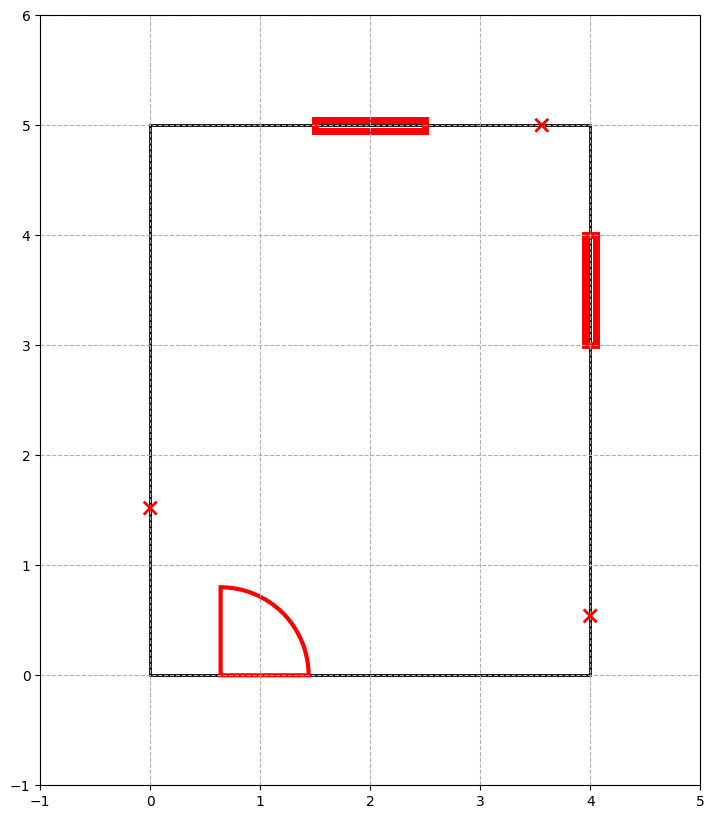

In [2]:
bedroom = create_room(4, 5)
create_fixed_object(bedroom, 'window', 1, 0.1, 'north', position = 0.5)
create_fixed_object(bedroom, 'window', 1, 0.1, 'east', position = 0.75)
create_fixed_object(bedroom, 'door', 0.8, 0.1, 'south', position = 0.2)
create_fixed_object(bedroom, 'socket', 0.1, 0.1, 'west', position = 0.3)
create_fixed_object(bedroom, 'socket', 0.1, 0.1, 'east', position = 0.1)
create_fixed_object(bedroom, 'socket', 0.1, 0.1, 'north', position = 0.9)

bedroom.draw()

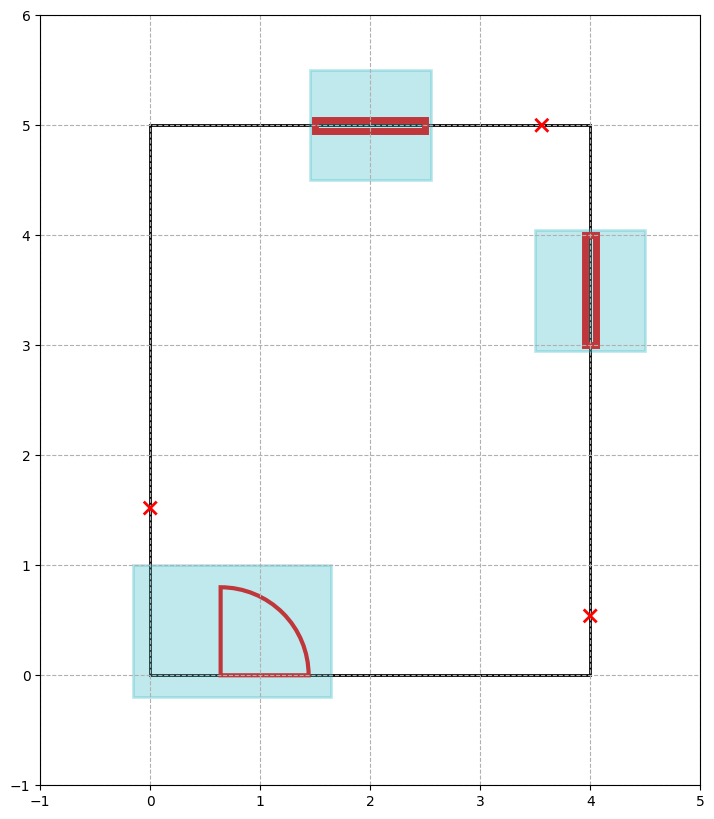

In [3]:
bedroom.draw(buffers = True)

# Get the primary objects, as well as all of their constraints. 

In [26]:
lang_prompt3 = "The room is described as " + scene_descriptor + ". Now for each one of the regions: " + region_names + """, 
what is the most important object to include, and what are its dimensions (give width of back of object and length of side of object but not height) 
in meters. ONLY one object per region (there can only be two of the same object if NECESSARY. If that is the case, output them as bed 1 and bed 2 or
chair 1 and chair 2). The size of the room is """ + width + "m x " + length + """m, bear this in mind when choosing the objects and the size 
of the objects. Give no other information please."""

lang3output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt3}],
        max_tokens=2000
    )

print(lang3output.choices[0].message.content)

lang_prompt4 = "For each of these objects: " + lang3output.choices[0].message.content + """, tell me all of the considerations and constraints
for its placement within the room that depend only on fixed features in the room like walls, windows, doors, sockets, etc. and return these as a 
bullet list for each object. Include practical things like whether it should be against a wall, or which side should be accessible for use 
(most objects will need an accessible constraint e.g. front of wardrobe needs to be accessible - however very few objects need all of their sides to be accessible.) etc. 
Only give these constraints and considerations, no other information."""
 
lang4output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt4}],
        max_tokens=2000
    )

print(lang4output.choices[0].message.content)

lang_prompt5 = """ Tell me all of the constraints and considerations between the objects in this list""" + lang3output.choices[0].message.content + """ that depend only on each other.
For example, maybe a desk should not be close to a bed, etc. Only give the constraints and considerations between objects, no other information.."""

lang5output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt5}],
        max_tokens=2000
    )

print(lang5output.choices[0].message.content)

1. Sleeping area: Bed 1 - 2m x 1.5m
2. Storage area: Wardrobe - 1.5m x 0.6m
3. Dressing area: Mirror - 1m x 0.05m
4. Reading or relaxation nook: Chair - 1m x 0.8m
### Sleeping area: Bed 1 - 2m x 1.5m
- Place against a wall for support and to save space.
- Ensure at least one side (preferably the longer side) is accessible for ease of getting in and out.
- Avoid placing under windows to prevent cold drafts and noise disturbances.
- Avoid blocking any doors.
- Consider proximity to power sockets for charging electronic devices.
- Should not block pathways for safety and ease of movement.

### Storage area: Wardrobe - 1.5m x 0.6m
- Place against a solid wall for stability.
- Ensure the front of the wardrobe is fully accessible for opening doors/drawers.
- Avoid placing in front of windows to allow natural light into the room.
- Ensure it doesn't block any doors or walkways.
- Proximity to the bed or dressing area for convenience.

### Dressing area: Mirror - 1m x 0.05m
- Place against a w

# Get the Secondary objects, as well as all of their constraints

In [27]:
lang_prompt6 = "Given a room described as: " + scene_descriptor + ", with size: " + str(width) + "m x " + str(length) + """ m with these regions within 
it:""" + region_names + ", and these primary objects already in it: " + lang3output.choices[0].message.content + """, what other objects should be added in? 
Give me 0-4 objects per region (depending on the size of the room - fewer objects for smaller rooms, and more objects for larger room) that should be added 
into the room (so make sure they are the most appropriate/necessary objects). Objects should be things like furniture or plants or other objects that sit on the floor.
For each one, make sure that they make sense to go into one of the regions, and tell me which region they should go into. There can be more than one of 
each object kind (eg. multiple dining chairs or multiple nightstands). Make sure to also give the dimensions of every object in meters (width of the back 
of the object and length  of the side of the object but NOT HEIGHT). Remove any objects that are not placed directly on the floor, e.g. table lamp,
and remove any objects that are mounted on the wall (e.g. paintings). Only give objects that get placed onto the floor. Give no other text in the response. 
Only the list of objects."""

lang6output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt6}],
        max_tokens=1000
    )

print(lang6output.choices[0].message.content)

lang_prompt7 = """For each of these objects""" + lang6output.choices[0].message.content + """, tell me all of the considerations and constraints for its placement 
within the room that depends only on fixed features in the room like walls, windows, doors, sockets, etc. (return these as a bullet list for each object). 
Include practical things like whether it should be against a wall and what side of the object (one of: left, right, top/back, bottom/front) of it should be
against a wall (don't describe this as long or short side, if its something like a headboard or the back of a sofa that would be 'back' etc.), 
or which side should be accessible for use (Most objects will have an accessible constraint - this would be something like the wardrobe needs to be accessible 
from the front so that the doors can open, or the bed needs to be accessible from the sides - but only give necessary accessible constraints. If an object can have
its side against something, then don't say its side needs to be accessible e.g. for a nightstand, etc). Don't include any constraints that depend on other objects. 
Only give these constraints and considerations, no other information. """
lang7output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt7}],
        max_tokens=2000
    )

print(lang7output.choices[0].message.content)

lang_prompt8 = """ Tell me all of the constraints and considerations between the objects in this list""" + lang6output.choices[0].message.content + """ as well as 
in this list """ + lang3output.choices[0].message.content + """. For example, a desk chair should have its front against the front of the desk, or the left side of one 
of the nightstands should be against the right side of the bed, etc.  Be specific with relationships between objects to include sides (one of: left, right, top/back, bottom/front) 
if appropriate, or minimum/maximum distances between objects etc.
Only give the constraints and considerations between objects, no other information."""

lang8output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt8}],
        max_tokens=2000
    )

print(lang8output.choices[0].message.content)

1. Sleeping area: Nightstand - 0.5m x 0.5m
2. Sleeping area: Coffin - 2m x 1m
3. Storage area: Chest of Drawers - 1m x 0.5m
4. Dressing area: Dressing Table - 1.2m x 0.6m
5. Reading or relaxation nook: Small Bookshelf - 0.6m x 0.3m
1. **Nightstand - 0.5m x 0.5m**
   - Back should be against a wall
   - Accessible from the front

2. **Coffin - 2m x 1m**
   - Top/back should be against a wall
   - Accessible from the front

3. **Chest of Drawers - 1m x 0.5m**
   - Back should be against a wall
   - Accessible from the front

4. **Dressing Table - 1.2m x 0.6m**
   - Back should be against a wall
   - Accessible from the front

5. **Small Bookshelf - 0.6m x 0.3m**
   - Back should be against a wall
   - Accessible from the front
1. The Nightstand should be placed with its right side against the left side of the Coffin.
2. The Coffin should be placed with its bottom/front parallel to the bottom/front of the Chest of Drawers, maintaining a minimum distance of 0.5m.
3. The Chest of Drawers sh

# Add all the objects into the room 
### Region by region. 

In [28]:
prompt4 = "Given this list of the objects: " + lang3output.choices[0].message.content +  lang6output.choices[0].message.content + ", use the file attached to create the objects with the correct parameters."
prompt4 += "The room name is: " + room_name + ", the region names are: " + str(list_region_names) + "."
prompt4 += "The room is already set up, only add in the objects using the 'create_moving_object' function. Ensure that each objects index is unique"
prompt4 += "The objects should be added in the correct regions. I want the objects to be added region by region (i.e. all objects from region 0 should be added before region 1 objects are added). "
prompt4 += "This is the file: " + file_contents1
prompt4 += "No extra text, only the function calls. Don't have 'python' at the start of the code. Do not define ANY functions, only call them."

# Define the request payload
data = {
    "model": "gpt-4o",
    "messages": [
            {"role": "user", "content": prompt4}
            ]
    }
    
# Make the API call
response4 = requests.post(url, headers=headers, json=data)  
# Check the response
if response4.status_code == 200:
    response_data4 = response4.json()


    if "```" in response_data4['choices'][0]['message']['content']:
        list_objects = (response_data4['choices'][0]['message']['content']).split("\n")[1:-1]
        response4_1 = ""
        for i in range(len(list_objects)):
            response4_1 += list_objects[i] + "\n"
     
    lines = response_data4['choices'][0]['message']['content'].split("\n")
    response4_1 = []
    for line in lines: 
        if "create_moving_object" in line: 
            response4_1.append(line)
    response4_1 = ("\n").join(response4_1)
    
    response4_1 = response4_1.replace("create_moving_object(room,", "create_moving_object(" + room_name + ",")
    response4 = remove_identical_lines(response4_1).replace(room_name, "local_context[room_name]")

else:
    print('Failed to get a response')
    print(response4.text)

strings = response4.split("create_moving_object(local_context[room_name],")
primary_objects = []
for string in strings[1:]:
    if "'" in string: 
        primary_objects.append(string.split("'")[1])
    else:
        primary_objects.append(string.split('"')[1])

print(response4)

create_moving_object(local_context[room_name], 'bed 1', 2, 1.5, 'Sleeping area', 0)
create_moving_object(local_context[room_name], 'nightstand', 0.5, 0.5, 'Sleeping area', 1)
create_moving_object(local_context[room_name], 'coffin', 2, 1, 'Sleeping area', 2)
create_moving_object(local_context[room_name], 'wardrobe', 1.5, 0.6, 'Storage area', 3)
create_moving_object(local_context[room_name], 'chest of drawers', 1, 0.5, 'Storage area', 4)
create_moving_object(local_context[room_name], 'mirror', 1, 0.05, 'Dressing area', 5)
create_moving_object(local_context[room_name], 'dressing table', 1.2, 0.6, 'Dressing area', 6)
create_moving_object(local_context[room_name], 'chair', 1, 0.8, 'Reading or relaxation nook', 7)
create_moving_object(local_context[room_name], 'small bookshelf', 0.6, 0.3, 'Reading or relaxation nook', 8)


In [29]:
object_creations = ['' for i in range(2*num_regions)]
lines = response4.split("\n")
for i in range(num_regions):
    sub_lines = [line for line in lines if list_region_names[i] in line]
    object_creations[2*i] = sub_lines[0]
    object_creations[2*i + 1] = "\n".join(sub_lines[1:])

primary_objects = []
secondary_objects = []
primary_object_indices = []

for name in list_region_names:
    lines = [i for i in response4.split("\n") if name in i and 'create_moving_object' in i]
    if "'" in lines[0]: 
        name = lines[0].split("'")[1]
    else:
        name = lines[0].split('"')[1]
    index = int(lines[0].split(", ")[-1].split(")")[0])
    primary_object_indices += [index]
    primary_objects += [name]

    for line in lines[1:]:
        if "'" in line: 
            name = line.split("'")[1]
        else:
            name = line.split('"')[1]
        secondary_objects += [name]

secondary_object_indices = [i for i in range(len(secondary_objects) + len(primary_objects)) if i not in primary_object_indices]

# Find the Primary Optimization Functions

In [30]:
prompt5 = "Given the room_name " + room_name + " as well as the primary objects: " + str(primary_objects) + """, as well as their 
indices""" + str(primary_object_indices) + " and these constraints: " + lang4output.choices[0].message.content + """. Using the script attached, 
transform each constraint into function calls that will ensure that the primary objects are set up correctly. Match each constraint to the closest 
function in the script file by using the docstrings. If you cannot find a function that matches the constraint, leave it out. 
Here is the first script: """ + file_contents2 + """. For the second script, I want you to transform the pairwise constraints into function calls.
Here is the second script: """ + file_contents3 + ", and here is the list of pairwise constraints: " + lang5output.choices[0].message.content + """I want 
the output to begin with: def optimize_primary_objects(positions, room): \n output = 0,  followed by each constraint function call added to the output, 
and then the output returned. No extra text please, only the functions and the output. 
Do not define ANY functions, only call them. ENSURE that all parameters match docstrings."""

# Define the request payload
data = {
    "model": "gpt-4o",
    "messages": [
            {"role": "user", "content": prompt5}
            ]
    }
    
# Make the API call
response5 = requests.post(url, headers=headers, json=data)  
# Check the response
if response5.status_code == 200:
    response_data5 = response5.json()

    if "```" in response_data5['choices'][0]['message']['content']:
        list_objects = (response_data5['choices'][0]['message']['content']).split("\n")[1:-1]
        response5_1 = ""
        for i in range(len(list_objects)):
            response5_1 += list_objects[i] + "\n"
    else: 
        
        response5_1 = response_data5['choices'][0]['message']['content']

    response5 = remove_identical_lines(response5_1)
    lines = response5.split("\n")
    for line in lines: 
        if "ind_in_region" in line: 
            lines.remove(line)
    response5 = ("\n").join(lines)
    indent = (response5.split("output")[0]).split("\n")[1]
    whole_calls = ["output += in_bounds(positions, room)\n" + indent, "output += no_overlap(positions, room)\n" + indent, "output += aligned(positions, room)\n" + indent, "output += balanced(positions, room)\n" + indent + "return"]
    new = response5.split("return")[0] 
    for call in whole_calls: 
        new += call 
    new += response5.split("return")[1]
    response5 = new
    print(response5)
    global_context = globals().copy()
    local_context = {}  
    exec(response5, global_context, local_context)
else:
    print('Failed to get a response')
    print(response5.text)

def optimize_primary_objects(positions, room):
    output = 0

    # Constraints for bed 1
    output += ind_next_to_wall(positions, room, 0)
    output += ind_accessible(positions, room, 0, ['left', 'front'])
    output += ind_away_from_fixed_object(positions, room, 0, 'window')
    output += ind_not_block_fixed_object(positions, room, 0, 'door')
    output += ind_close_to_fixed_object(positions, room, 0, 'socket')
    output += ind_accessible(positions, room, 0, [])
    # Constraints for wardrobe
    output += ind_next_to_wall(positions, room, 3)
    output += ind_accessible(positions, room, 3, ['front'])
    output += ind_not_block_fixed_object(positions, room, 3, 'window')
    output += ind_not_block_fixed_object(positions, room, 3, 'door')
    # Constraints for mirror
    output += ind_next_to_wall(positions, room, 5)
    output += ind_not_block_fixed_object(positions, room, 5, 'window')
    # Constraints for chair
    output += ind_next_to_wall(positions, room, 7)
    output += i

In [31]:
primary_functions = []
lines = response5.split("\n")
for i in primary_object_indices[::-1]:#range(num_primary_objects - 1, -1, -1):
    lines_to_remove = []
    ## I need to split the optimization function into multiple different functons
    function = ("\n").join(lines[:2])
    for line in lines:
        sub_sections = line.split(room_name + ", ")
        if "no_overlap" in line:
            function += "\n" + line
        if "in_bounds" in line:
            function += "\n" + line
        if "aligned" in line:
            function += "\n" + line
        if "balanced" in line:
            function += "\n" + line
        if "return" in line: 
            function += "\n" + line
        for j in sub_sections: 
            if str(i) + "," in j or str(i) + ")" in j:
                function += "\n" + line
                lines_to_remove += [line]
                break 
    for line in lines_to_remove:
        lines.remove(line)
    primary_functions = [function] + primary_functions

In [32]:
new_primary_functions = primary_functions.copy()
primary_accessible_constraints = [[] for i in range(num_primary_objects)]
for obj_index in range(num_primary_objects):
    for i in primary_functions[obj_index].split("\n"):
        if "ind_accessible" in i: 
            primary_accessible_constraints[obj_index].append(i)

    primary_accessible_constraints[obj_index] = "\n" +("\n").join(primary_accessible_constraints[obj_index])

for i in range(num_regions):
    if i > 0: 
        for j in primary_accessible_constraints[i - 1].split("\n"):
            if j not in primary_accessible_constraints[i]:
                primary_accessible_constraints[i] += "\n" + j

for i in range(num_regions): 
    for j in primary_accessible_constraints[i].split("\n"):
        if j not in primary_functions[i].split("\n"):
            new_primary_functions[i] = primary_functions[i].split("return")[0] + "\n" + j + "\n    return" + primary_functions[i].split("return")[1]

# Get the Secondary Optimization Functions

In [33]:
objects_per_region =[[] for i in range(num_regions)]
for i in range(len(primary_objects)):
    if i < len(primary_objects) - 1:
        objects_per_region[i] = [j for j in range(primary_object_indices[i], primary_object_indices[i + 1])]
    else:
        objects_per_region[i] = [j for j in range(primary_object_indices[i], len(primary_objects) + len(secondary_objects))]

object_regions = [list_region_names[k] for k in range(num_regions) for i in objects_per_region[k][1:]]
obj_ind = [(secondary_objects[i], secondary_object_indices[i], object_regions[i]) for i in range(len(secondary_objects))]


In [34]:
prompt6 = "Given the primary objects: " + str(primary_objects) + " and their indices: " + str(primary_object_indices) + """, as well as the secondary
objects, along with their indices, and then their regions """ + str(obj_ind) + """, and their individual 
constraints: """ + lang7output.choices[0].message.content + ", and these are the region names: " + region_names + """. Using the script attached, 
transform each constraint into function calls that will ensure that the secondary objects are set up correctly. Match each constraint to the closest
function in the script file by using the docstrings. If you cannot find a function that matches the constraint, leave it out. 
Here is the first script: """ + file_contents2 + """. For the second script, I want you to transform the pairwise constraints into function calls. 
Here is the second script: """ + file_contents3 + ", and here is the list of pairwise constraints: " + lang8output.choices[0].message.content + """. 
I want the output to begin with: ’def optimize_secondary_objects(positions, room): \n output = 0\n’, followed by each constraint function call 
added to the output, (each line should begin with 'output +=').
Also ensure to use ind_in_region for each object. Do not define ANY functions, only call them. No extra text please, only the functions and the output."""

# Define the request payload.
data = {
    "model": "gpt-4o",
    "messages": [
            {"role": "user", "content": prompt6}
            ]
    }
    
# Make the API call
response6 = requests.post(url, headers=headers, json=data)  
# Check the response
if response6.status_code == 200:

    if "```" in response6.json()['choices'][0]['message']['content']:
        list_objects = (response6.json()['choices'][0]['message']['content']).split("\n")[1:-1]
        response6_1 = ""
        for i in range(len(list_objects)):
            response6_1 += list_objects[i] + "\n"
    else: 
        
        response6_1 = response6.json()['choices'][0]['message']['content']
    
    indent1 = response6_1.split("output")[0].split("\n")[1]
    response6 = "def optimize_secondary_objects(positions, room):\n" + indent1 + "output = 0\n"
    response6 += indent1 + "\n" + ("\n").join((response6_1.split("return")[0]).split("\n")[2:]) + "\n" + indent1 + "return output \n"

    whole_calls = ["output += in_bounds(positions, room)\n" + indent1, "output += no_overlap(positions, room)\n" + indent1, "output += aligned(positions, room)\n" + indent1 + "return"]
    new = response6.split("return")[0] 
    for call in whole_calls: 
        new += call 
    new += response6.split("return")[1]
    response6 = new
    
    print(response6)

else:
    print('Failed to get a response')
    print(response6.text)



def optimize_secondary_objects(positions, room):
    output = 0
    

    # Constraints for nightstand
    output += ind_next_to_wall(positions, room, 1)
    output += ind_accessible(positions, room, 1, ['front'])
    output += ind_in_region(positions, room, 1, 'Sleeping area')
    
    # Constraints for coffin
    output += ind_next_to_wall(positions, room, 2)
    output += ind_accessible(positions, room, 2, ['front'])
    output += ind_in_region(positions, room, 2, 'Sleeping area')
    
    # Constraints for chest of drawers
    output += ind_next_to_wall(positions, room, 4)
    output += ind_accessible(positions, room, 4, ['front'])
    output += ind_in_region(positions, room, 4, 'Storage area')
    
    # Constraints for dressing table
    output += ind_next_to_wall(positions, room, 6)
    output += ind_accessible(positions, room, 6, ['front'])
    output += ind_in_region(positions, room, 6, 'Dressing area')
    
    # Constraints for small bookshelf
    output += ind_next_to_wall(

In [35]:
secondary_functions = ['' for i in range(num_regions)]
lines = response6.split("\n")
for i in range(num_regions - 1, -1, -1):
    function = ("\n").join(lines[:2])
    function += ("\n").join(primary_accessible_constraints[:i + 1])
        

    for obj_index in objects_per_region[i]:
        lines_to_remove = []
        for line in lines:
            sub_sections = line.split(room_name + ", ")

            if "ind_accessible" in line and str(obj_index) in line:
                function += "\n" + line

            for j in sub_sections: 
                if str(obj_index) + "," in j or str(obj_index) + ")" in j:
                    function += "\n" + line
                    lines_to_remove += [line]
                    break 
    
        for line in lines_to_remove:
            if line in lines: 
                lines.remove(line)
    for line in lines: 
        if "no_overlap" in line:
            function += "\n" + line
        if "in_bounds" in line:
            function += "\n" + line
        if "aligned" in line: 
            function += "\n" + line
        if "return" in line: 
            function += "\n" + line

            
    secondary_functions[i] = remove_identical_lines(function)

In [36]:
for i in secondary_functions: 
    print(i)

def optimize_secondary_objects(positions, room):
    output = 0
    output += ind_accessible(positions, room, 0, ['left', 'front'])
    output += ind_accessible(positions, room, 0, [])
    output += ind_next_to_wall(positions, room, 1)
    output += ind_accessible(positions, room, 1, ['front'])
    output += ind_in_region(positions, room, 1, 'Sleeping area')
    output += p_next_to(positions, room, 1, 2, 'right', 'left')  # Nightstand next to Coffin
    output += ind_next_to_wall(positions, room, 2)
    output += ind_accessible(positions, room, 2, ['front'])
    output += ind_in_region(positions, room, 2, 'Sleeping area')
    output += in_bounds(positions, room)
    output += no_overlap(positions, room)
    output += aligned(positions, room)
    return output 
def optimize_secondary_objects(positions, room):
    output = 0
    output += ind_accessible(positions, room, 0, ['left', 'front'])
    output += ind_accessible(positions, room, 0, [])

    output += ind_accessible(positions, roo

In [37]:
new_secondary_functions = secondary_functions.copy()
secondary_accessible_constraints = [[] for i in range(len(secondary_objects))]
for region in range(num_regions):
    for i in secondary_functions[region].split("\n"):
        if "ind_accessible" in i:
            secondary_accessible_constraints[region].append(i)

    secondary_accessible_constraints[region] = "\n" +("\n").join(secondary_accessible_constraints[region])

for i in range(num_regions):
    if i > 0: 
        for j in secondary_accessible_constraints[i - 1].split("\n"):
            if j not in secondary_accessible_constraints[i]:
                secondary_accessible_constraints[i] += "\n" + j

for i in range(num_regions): 
    for j in secondary_accessible_constraints[i].split("\n"):
        if j not in secondary_functions[i].split("\n"):
            new_secondary_functions[i] = secondary_functions[i].split("return")[0] + "\n" + j + "\n    return" + secondary_functions[i].split("return")[1]

secondary_functions = new_secondary_functions.copy()

In [38]:
final_function = "def optimize(positions, room):\n"
final_function += ("\n").join(response5.split("\n")[1:]).split("return")[0] + "\n"
final_function += response6.split("output = 0")[1] + "\n"

In [39]:
for i in secondary_functions: 
    print(i)

def optimize_secondary_objects(positions, room):
    output = 0
    output += ind_accessible(positions, room, 0, ['left', 'front'])
    output += ind_accessible(positions, room, 0, [])
    output += ind_next_to_wall(positions, room, 1)
    output += ind_accessible(positions, room, 1, ['front'])
    output += ind_in_region(positions, room, 1, 'Sleeping area')
    output += p_next_to(positions, room, 1, 2, 'right', 'left')  # Nightstand next to Coffin
    output += ind_next_to_wall(positions, room, 2)
    output += ind_accessible(positions, room, 2, ['front'])
    output += ind_in_region(positions, room, 2, 'Sleeping area')
    output += in_bounds(positions, room)
    output += no_overlap(positions, room)
    output += aligned(positions, room)
    

    return output 
def optimize_secondary_objects(positions, room):
    output = 0
    output += ind_accessible(positions, room, 0, ['left', 'front'])
    output += ind_accessible(positions, room, 0, [])

    output += ind_accessible(position

In [40]:
def p_infront(positions, room, object1_index, object2_index, dist = 0.8):
    """ The function p_infront ensures that object1 is in front of object2 (both moving_objects i.e. not windows or doors). E.g a coffee table should be in front of a sofa....

        Args:
        positions: list of floats, x, y, theta values for all objects in the room
        room: rectangular Room object
        object1_index: int, Object object
        object2_index: int, Object object
        dist: float, desired distance between two objects. E.g. if its a sofa and a coffee table, the distance should be around 0.8m, 
                                                            if its a sofa and a fireplace, the distance should be around 2m/2.5m.
    """

    ## want object1 position to be in front of object2 position in the frame of object2
    x1, y1, theta1 = get_position(positions, room, object1_index)
    x2, y2, theta2 = get_position(positions, room, object2_index)

    obj1 = room.moving_objects[object1_index]
    obj2 = room.moving_objects[object2_index]

    cs2 = corners(x2, y2, theta2, obj2.width, obj2.length) # TL, TR, BR, BL
    mid_front = np.array([(cs2[2][0] + cs2[3][0])/2, (cs2[2][1] + cs2[3][1])/2])
    mid2front = np.array([mid_front[0] - x2, mid_front[1] - y2])
    mid2front /= np.linalg.norm(mid2front)

    half_diag = np.sqrt(obj1.width**2 + obj1.length**2)/2
    projection = mid_front + (dist + half_diag) * mid2front
    val = (projection[0] - x1)**2 + (projection[1] - y1)**2
    return 3*val

# Run the code !

Adding in the primary object:  bed 1
New best result found. Cost:  1.5630079945918518
New best result found. Cost:  1.562505753992694
New best result found. Cost:  1.562500313966413
New best result found. Cost:  1.5625002864919753
New best result found. Cost:  1.5625000762961474
100


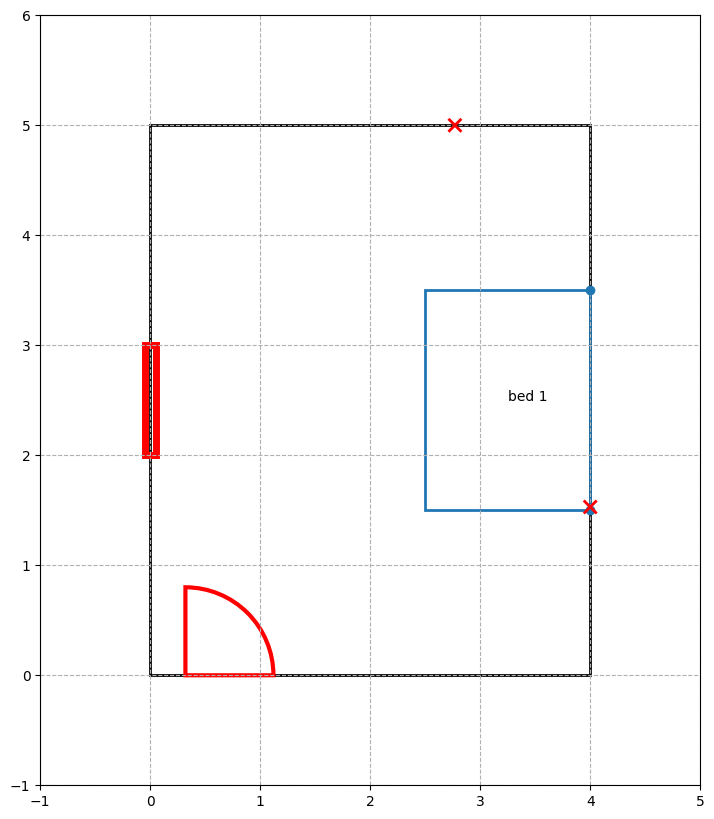

Adding in the secondary objects:  ['nightstand', 'coffin']
Iteration 1 , New best result found. Cost:  7.349339949783669 overlap:  0 bounds:  0.012879400601602212
Iteration 2 , New best result found. Cost:  0.04607665393962672 overlap:  0 bounds:  3.8510389675724866e-10
Iteration 7 , New best result found. Cost:  0.04605708466497744 overlap:  0 bounds:  0
Iteration 29 , New best result found. Cost:  0.046054772488448394 overlap:  0 bounds:  1.5273005472194546e-13


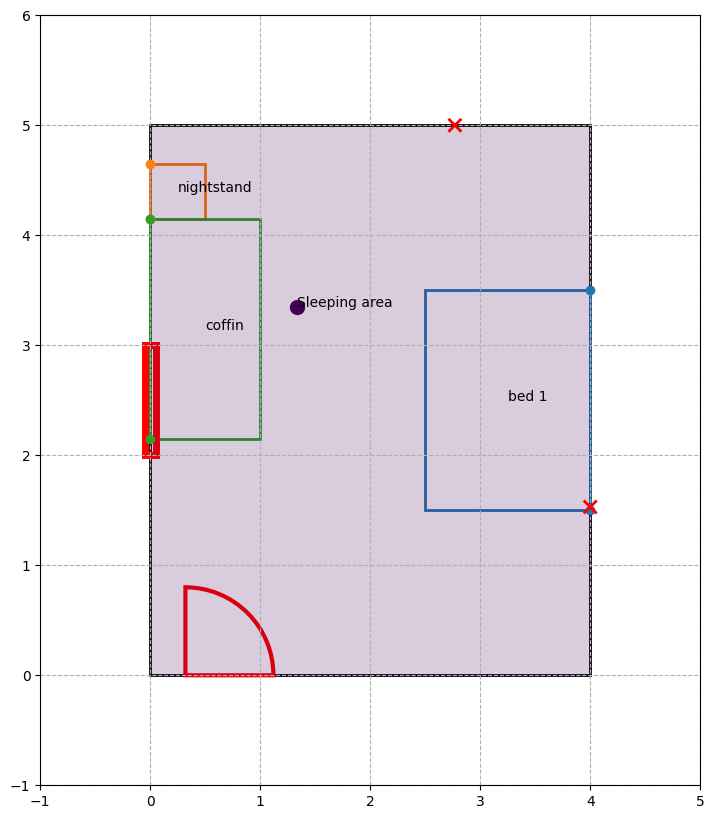

Adding in the primary object:  wardrobe
New best result found. Cost:  0.6059044083078785
New best result found. Cost:  0.6017391220508999
100


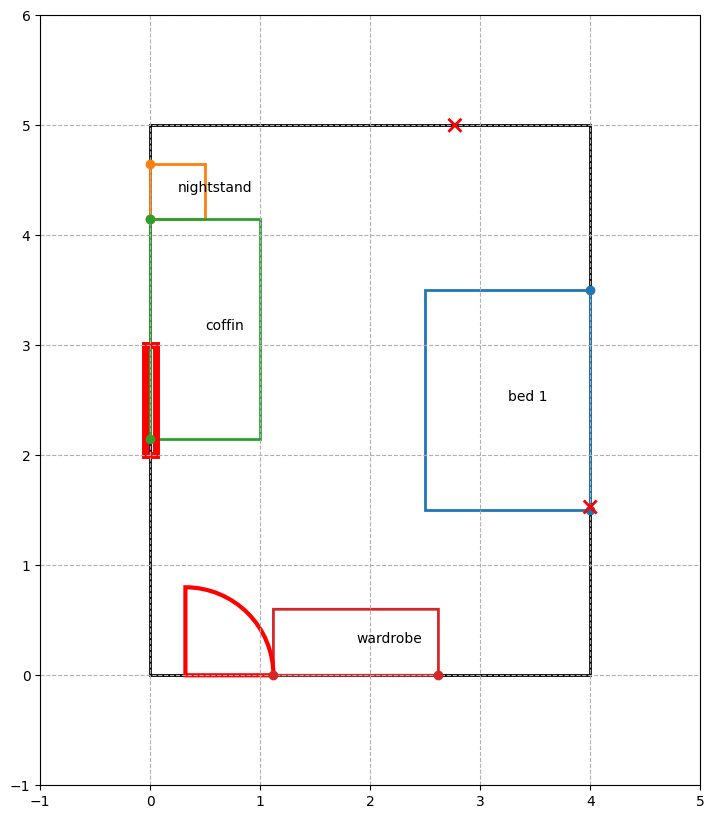

Adding in the secondary objects:  ['chest of drawers']
Iteration 1 , New best result found. Cost:  11.408744343727179 overlap:  0 bounds:  0.0008265908395890796
Iteration 6 , New best result found. Cost:  10.524291188731953 overlap:  0 bounds:  5.3577022348149846e-05


/Users/gabriellelittlefair/miniforge3/envs/MV00/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


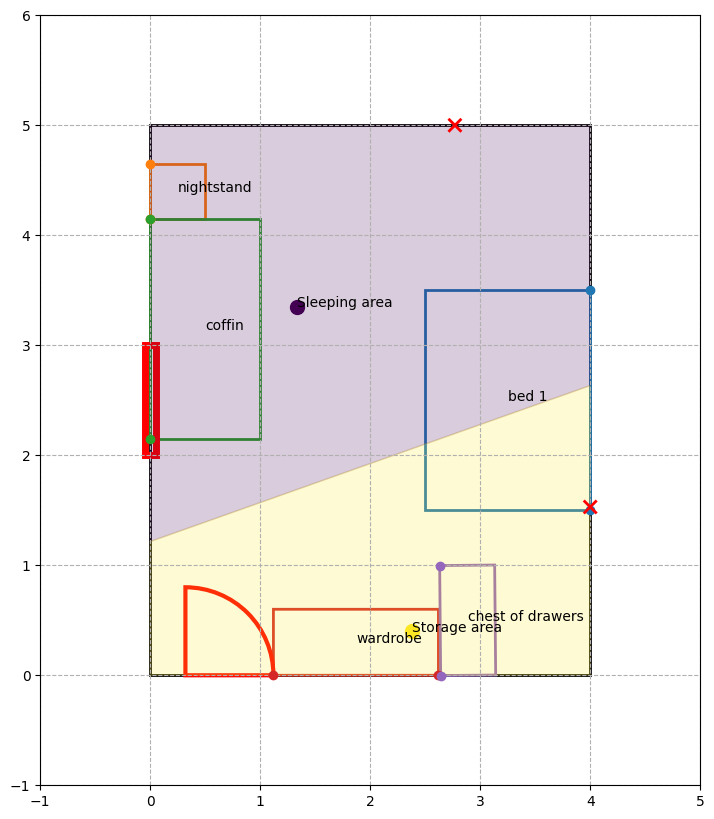

Adding in the primary object:  mirror
New best result found. Cost:  2.8412909033214193
New best result found. Cost:  2.841260417942747
New best result found. Cost:  0.09281650891623855
New best result found. Cost:  0.09265775738008086
New best result found. Cost:  0.04228951204219958
100


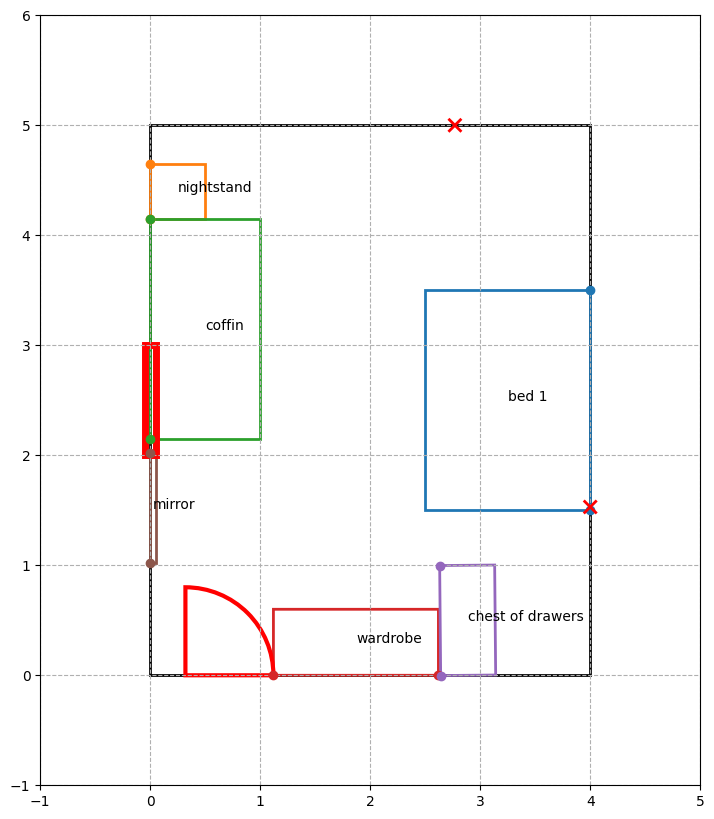

Adding in the secondary objects:  ['dressing table']
Iteration 1 , New best result found. Cost:  4.4018082942680055 overlap:  0 bounds:  5.357702346776922e-05
Iteration 2 , New best result found. Cost:  4.396118916157284 overlap:  9.29509274005016e-05 bounds:  5.357702346776922e-05
Iteration 8 , New best result found. Cost:  4.396117758423967 overlap:  7.544479299149136e-05 bounds:  5.357702346776922e-05
Iteration 16 , New best result found. Cost:  4.396117664107726 overlap:  7.56455559942916e-05 bounds:  5.357702346776922e-05
Iteration 56 , New best result found. Cost:  4.396117598940814 overlap:  7.904080774697013e-05 bounds:  5.357702346776922e-05
Iteration 87 , New best result found. Cost:  4.396117561833967 overlap:  7.884621064974413e-05 bounds:  5.357702346776922e-05


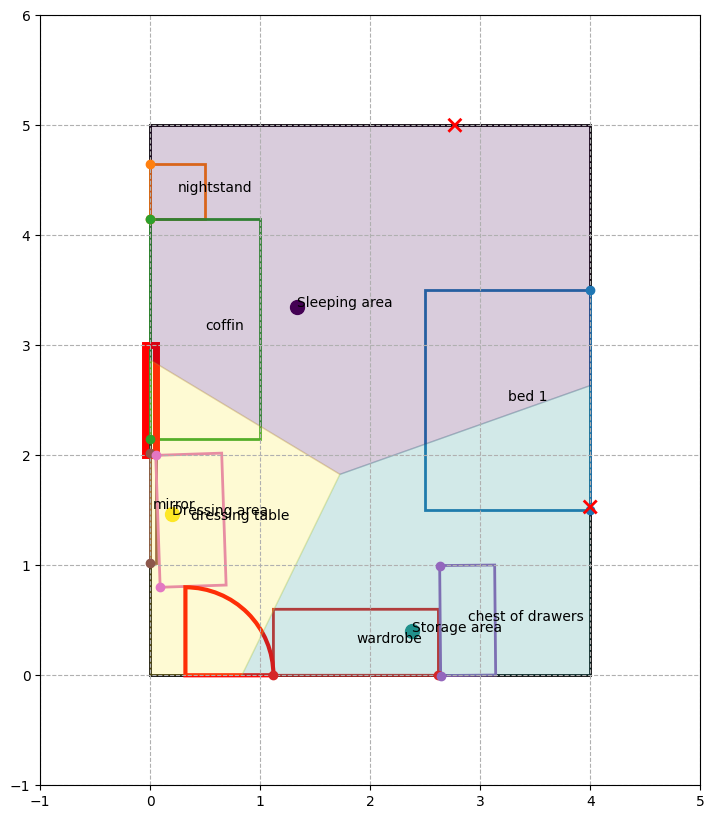

Adding in the primary object:  chair
New best result found. Cost:  2.1524822700322
New best result found. Cost:  2.1524822447944874
New best result found. Cost:  2.1524822260569465
New best result found. Cost:  2.1524822240649035
100


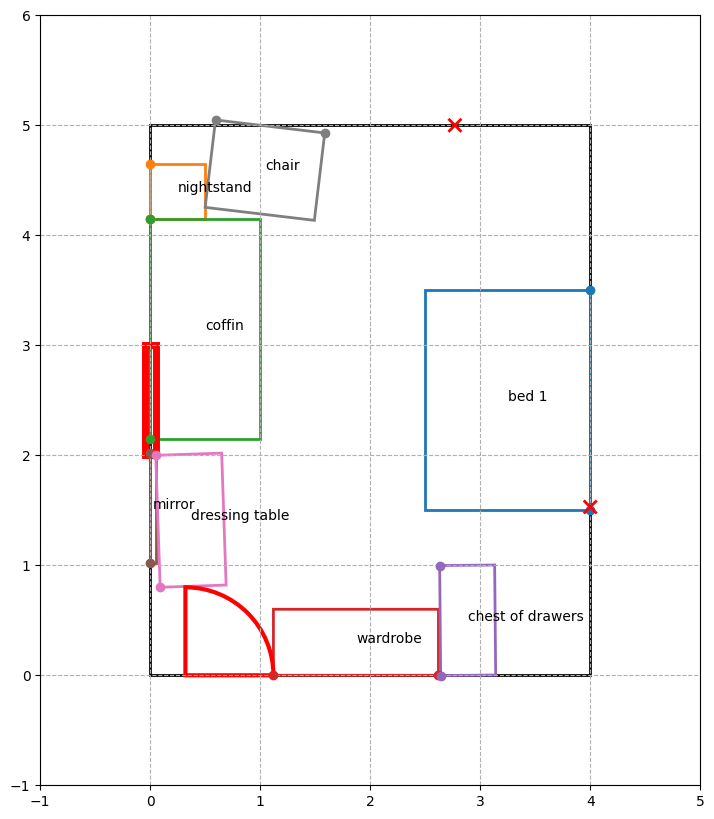

Adding in the secondary objects:  ['small bookshelf']
Iteration 7 , New best result found. Cost:  21.066970141330977 overlap:  0.11465562293476567 bounds:  0.023395127860201807
Iteration 8 , New best result found. Cost:  20.658330856382616 overlap:  0.05867426360325312 bounds:  0.023395127860201807
Iteration 12 , New best result found. Cost:  20.393666047786386 overlap:  0.04342503643645891 bounds:  0.023395127860201807
Iteration 19 , New best result found. Cost:  20.393666040823994 overlap:  0.04343855539097817 bounds:  0.023395127860201807
Iteration 22 , New best result found. Cost:  19.34211149140201 overlap:  0.0006169715728918299 bounds:  0.023395127860201807
Iteration 63 , New best result found. Cost:  19.214479128014244 overlap:  0.12402174656869355 bounds:  0.023395127860201807


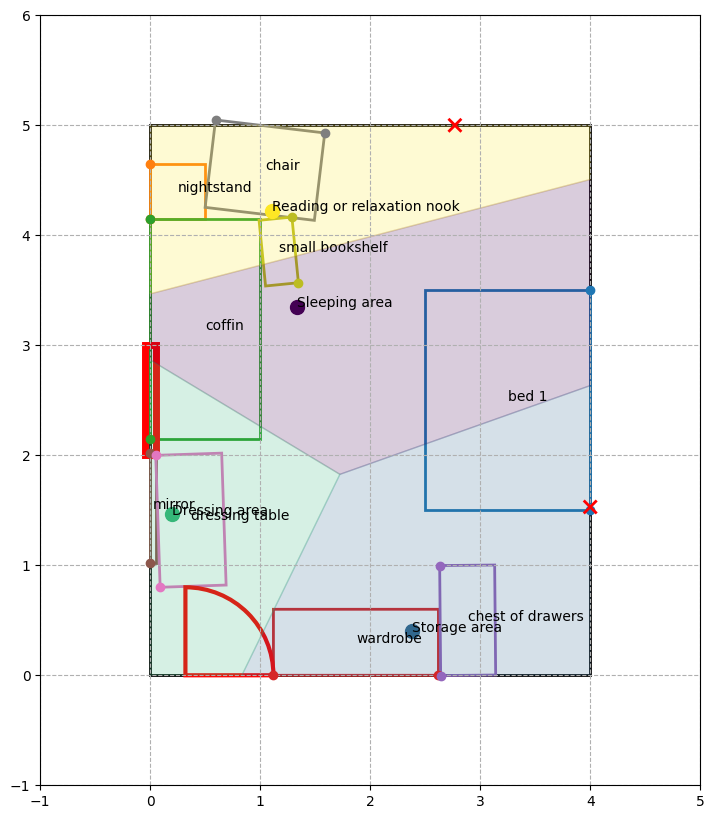

Time taken:  283.22289299964905


In [41]:
global_context = globals().copy()
local_context = {}
local_context2 = {}
exec(response1, global_context, local_context)

for region in range(num_regions):
    exec(primary_functions[region], global_context, local_context) # define the very first optimizaton function 
    ## Now want to add in the first primary object
    exec(region_setups[region] + "\n" + object_creations[2*region]) # add in the region
    print("Adding in the primary object: ", primary_objects[region])

    options = {'maxiter': 300, 'ftol': 1e-6}
    iters = 0
    min_fun = np.Inf
    room = local_context[room_name]
    func = local_context['optimize_primary_objects']
    while min_fun > 1e-2 and iters <100:
        positions = np.zeros(3)
        for i in range(len(room.moving_objects) - len(room.fm_indices)):
            positions[3*i] = np.random.uniform(0, room.width)
            positions[3*i + 1] = np.random.uniform(0, room.length)
            positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
        res = minimize(func, positions, args = (room), method = 'SLSQP', options = options) 
        iters += 1
        if res.fun < min_fun:
            if not no_overlap(res.x, room) > 0.4 and not in_bounds(res.x, room) > 0.4:
                min_fun = res.fun
                best_res = res
                print("New best result found. Cost: ", min_fun)

    print(iters)
    for i in range(len(room.fm_indices), len(room.moving_objects)): 
        j = i - len(room.fm_indices)
        room.moving_objects[i].position = best_res.x[3*j:3*j + 3] 
    room.draw() 
    prime_index = primary_object_indices[region]

    room.regions[region].x, room.regions[region].y = room.moving_objects[prime_index].position[0], room.moving_objects[prime_index].position[1]
    prev_cost = min_fun 

    room.fm_indices += [i for i in range(len(room.fm_indices), len(room.moving_objects))]
    
    exec(object_creations[2*region + 1]) # add in the secondary objects for the region
    exec(secondary_functions[region], global_context, local_context) # define the optimization function for the secondary objects

    room = local_context[room_name]
    func = local_context['optimize_secondary_objects']

    print("Adding in the secondary objects: ", [room.moving_objects[i].name for i in objects_per_region[region]][1:])

    num = len(room.moving_objects) - len(room.fm_indices)
    bounds = Bounds([-10] * 3 * num, [room.width + 10, room.length + 10, np.Inf] * num)
    iters = 0
    min_fun = np.Inf
    best_res2 = None
    while (min_fun > 5e-2 and best_res2 is None and iters < 150) or (best_res2 and iters < 100):
        if iters == 149: 
            print("Iteration 150, no solution found, putting the objects outside of the room.")
            best_res2 = res
            best_res2.x = np.array([room.width + 3, room.length + 3, 0] * num)
        positions = np.zeros(3*num)
        for i in range(num):
            positions[3*i] = np.random.uniform(0, room.width)
            positions[3*i + 1] = np.random.uniform(0, room.length)
            positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
        res = minimize(func, positions, args = (room), method = 'SLSQP', options = options, bounds = bounds)
        iters += 1
        if res.fun < min_fun:
            if not no_overlap(res.x, room) > 0.4 and not in_bounds(res.x, room) > 0.4:
                min_fun = res.fun 
                best_res2 = res
                print("Iteration", iters, ", New best result found. Cost: ", min_fun, "overlap: ", no_overlap(res.x, room), "bounds: ", in_bounds(res.x, room))
    
    for i in range(len(room.fm_indices), len(room.moving_objects)): 
        j = i - len(room.fm_indices)
        room.moving_objects[i].position = best_res2.x[3*j:3*j + 3] 

    room.regions[region].x = np.mean([i.position[0] for i in room.moving_objects if i.region == list_region_names[region]])
    room.regions[region].y = np.mean([i.position[1] for i in room.moving_objects if i.region == list_region_names[region]])

    room.draw(draw_regions = True) 

    room.fm_indices += [i for i in range(len(room.fm_indices), len(room.moving_objects))]
    prev_cost = min_fun 

end_time = time.time()
elapsed_time = end_time - start_time
print("Time taken: ", elapsed_time)

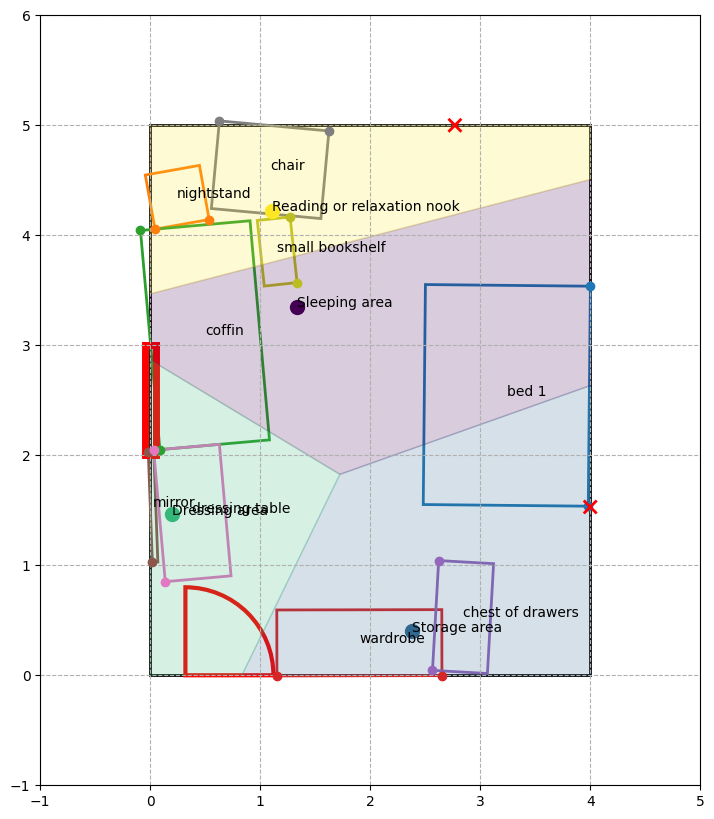

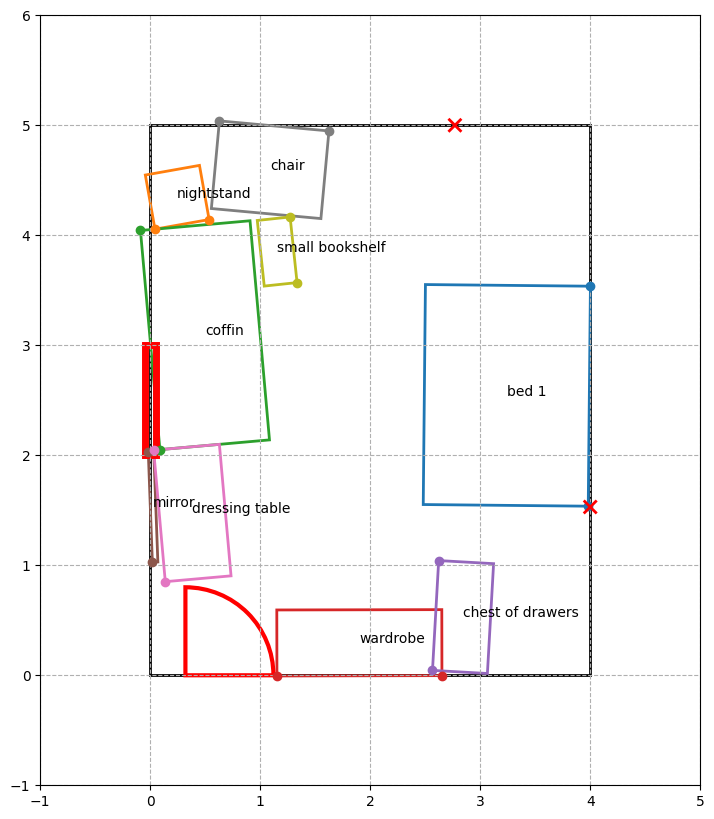

In [42]:
room.fm_indices = []
positions = np.zeros(3*len(room.moving_objects))
for i in range(len(room.moving_objects)):
    positions[3*i] = room.moving_objects[i].position[0]
    positions[3*i + 1] = room.moving_objects[i].position[1]
    positions[3*i + 2] = room.moving_objects[i].position[2]

exec(final_function, global_context, local_context2)
bounds = Bounds([0] * 3 * len(room.moving_objects), [room.width, room.length, np.Inf] * len(room.moving_objects))
func = local_context2['optimize']

res = minimize(func, positions, args = (room), method = 'SLSQP', options = options, bounds = bounds)
for i in range(len(room.moving_objects)):
    room.moving_objects[i].position = res.x[3*i:3*i + 3]
room.draw(draw_regions = True)
room.draw()